downloaded the data from 

In [1]:
fname = "jena_climate_2009_2016.csv"
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close()>

In [2]:
lines = data.split("\n")
header = lines[0].split(",") #seperating the headings from data
lines = lines[1:] #actual data

In [3]:
print(header)
length = len(lines)
print(length)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Converting data into nupmy

In [4]:
import numpy as np

In [6]:
header_length = len(header)
print (header_length)

15


In [7]:
float_data = np.zeros((length, header_length-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values #seperating each column with different climate properties

Ploting the temperature graph

In [11]:
from matplotlib import pyplot as plt

"T (degC)"


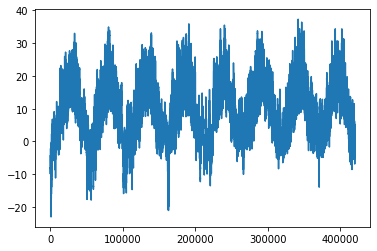

In [14]:
print(header[2])
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Ploting pressure graph

"p (mbar)"


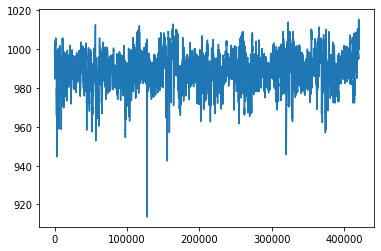

In [15]:
print(header[1])
pressure = float_data[:, 0]
plt.plot(range(len(pressure)), pressure)

Preparing the data

Normalizing the data

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Generating yielding timeseries samples and their targets

In [34]:
def generator (data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

Preparing training, validation, test generators

In [35]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [36]:
train_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 0, 
                      max_index = 200000, 
                      shuffle = True, 
                      batch_size = batch_size, 
                      step = step)

In [37]:
val_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 200001, 
                      max_index = 300000, 
                      batch_size = batch_size, 
                      step = step)

In [38]:
val_gen = generator(float_data, 
                      lookback = lookback, 
                      delay = delay, 
                      min_index = 300001, 
                      max_index = None, 
                      batch_size = batch_size, 
                      step = step)

In [39]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) -300001 - lookback)

Common Sense, non-machile learning baseline MAE

In [28]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples [:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [29]:
evaluate_naive_method()

StopIteration: 

Training and evaluating a densely connected model

In [30]:
import tensorflow as tf

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [32]:
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer = RMSprop(), loss = "mae")
history = model.fit_generator(train_gen, 
                              steps_per_epoch = 500, 
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.2878

plotting Graph

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")

plt.title("Training and Validation loss")
plt.legend()

plt.show()